# Example Notebook

This notebook provides an example in getting started with Stellar dataset. The notebook assumes that you have already familiarized yourself with the [README.md](https://github.com/stellar-gen-ai/stellar-dataset). 

The README.md contains instructions on how to download and process the dataset. After you have done so, you should have a folder, let's say output_dir, with the following structure:

    .
    ├── ...
    ├── output_dir                           # The datasets folder
    │   ├── STELLAR                          # The Stellar dataset folder
    │   │   ├── 000                          # Zeroth subject folder
    │   │   │   ├── 0.jpg                    # First image file
    │   │   │   ├── 0_bg.png                 # First image mask file
    │   │   │   ├── 0_attributes.json        # First image celeba annotations
    │   │   │   ├── 1.jpg                    # Second image file
    │   │   │   ├── 1_bg.png                 # Second image mask file
    │   │   │   ├── 1_attributes.json        # Second image celeba annotations
    │   │   │   ├── prompts_h.json           # Prompts-H file (only on test split)
    │   │   │   ├── prompts_t.json           # Prompts-T file
    │   │   │ ...
    └── ...

## Visualizing the dataset

In [1]:
import json
from collections import defaultdict
from itertools import chain
from os.path import join as pjoin

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
data_dict = {
    "stellar_h": [],
    "stellar_t": [],
}

for name in data_dict:
    with open(
        pjoin(
            "prompts",
            "{}.json".format(name),
        ),
        "r",
    ) as fp:
        data_dict[name] = json.load(fp)

prompts_dict = defaultdict(list)
for name, data in data_dict.items():
    prompts_dict[name] = [
        p.strip().replace("{}", "A person")
        for p in chain.from_iterable([dt["prompts"] for dt in data.values()])
    ]

### Prompt Stats

In [3]:
def prompts_stats(ds_name, prompts, plot_graph=True):
    prompts_len = np.array([len(prompt.split()) for prompt in prompts])
    unique_tokens = set(
        token for prompt in prompts for token in prompt.split()
    )
    if plot_graph:
        sns.histplot(
            prompts_len, discrete=True, kde=True, stat="density", kde_kws={'bw_method':1}
        )
        # sns.kdeplot(prompts_len, bw_method=1)
        plt.xlim(min(prompts_len), 20)

    print(f"Dataset {ds_name}")
    print(f"\tNumber of prompts: {len(prompts_len)}")
    print(f"\tAverage prompt length is: {prompts_len.mean()}")
    print(f"\tMedian prompt length is: {np.median(prompts_len)}")
    print(f"\tMax prompt length is: {prompts_len.max()}")
    print(f"\tMin prompt length is: {prompts_len.min()}")
    print(f"\tNumber of unique tokens: {len(unique_tokens)}")

Dataset stellar_h
	Number of prompts: 10000
	Average prompt length is: 8.8993
	Median prompt length is: 9.0
	Max prompt length is: 41
	Min prompt length is: 3
	Number of unique tokens: 7957
Dataset stellar_t
	Number of prompts: 10400
	Average prompt length is: 8.521057692307693
	Median prompt length is: 8.0
	Max prompt length is: 17
	Min prompt length is: 3
	Number of unique tokens: 669


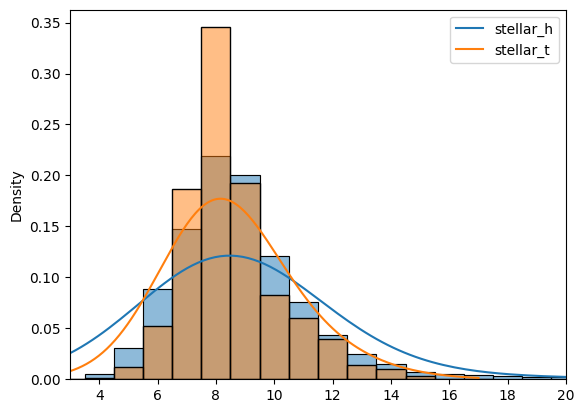

In [4]:
for ds_name, prompts in prompts_dict.items():
    prompts_stats(ds_name, prompts, plot_graph=True)
    plt.legend(prompts_dict.keys())

### POS (Part of Speech) Stats

In [5]:
nltk.download("universal_tagset")


def pos_stats(prompts, print_results=True):
    sentences = nltk.pos_tag_sents(
        list(map(nltk.word_tokenize, prompts)), tagset="universal"
    )

    pos_stats = {
        lbl: []
        for lbl in sorted(
            set(nltk.tag.tagset_mapping("en-ptb", "universal").values())
            - {".", "X"}
        )
    }

    for _, sentence in enumerate(sentences):
        for pos_key in pos_stats:
            pos_stats[pos_key].append([])
        for wd in sentence:
            if wd[1] not in pos_stats:
                continue
            pos_stats[wd[1]][-1].append(wd[0])

    if print_results:
        for pos_type, pos_values in pos_stats.items():
            print(
                "\t{: <10}".format(pos_type),
                "{: <8}".format(
                    np.array([len(wds) for wds in pos_values]).mean().round(3)
                ),
                "{: <8}".format(len(set(chain.from_iterable(pos_values)))),
            )

    return pos_stats

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/alex/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


#### Per Prompt Stats

In [6]:
for ds_name, prompts in prompts_dict.items():
    print(f"Dataset {ds_name}")
    pos_metadata = pos_stats(prompts)

Dataset stellar_h
	ADJ        0.333    937     
	ADP        1.288    70      
	ADV        0.031    103     
	CONJ       0.04     9       
	DET        2.386    19      
	NOUN       3.446    5071    
	NUM        0.018    60      
	PRON       0.099    20      
	PRT        0.142    15      
	VERB       1.131    1323    
Dataset stellar_t
	ADJ        0.121    65      
	ADP        1.407    20      
	ADV        0.0      0       
	CONJ       0.0      0       
	DET        2.575    4       
	NOUN       3.454    581     
	NUM        0.004    1       
	PRON       0.013    1       
	PRT        0.069    4       
	VERB       0.882    96      


#### Per Identity Stats (for test split)

In [7]:
prompts_per_id_dict = defaultdict(list)
for name, data in data_dict.items():
    prompts_per_id_dict[name] = [
        [p.strip().replace("{}", "A person") for p in dt["prompts"]]
        for dt in data.values()
    ]

In [8]:
merged = {
    ds_name: defaultdict(list)
    for ds_name in prompts_per_id_dict.keys()
}

for ds_name, prompts_per_id in prompts_per_id_dict.items():
    print(f"Dataset {ds_name}")

    for idx, id_prompts in enumerate(tqdm(prompts_per_id[:200])):
        pos_metadata = pos_stats(id_prompts, print_results=False)
        for key in pos_metadata.keys():
            merged[ds_name][key].append(list(chain.from_iterable(pos_metadata[key])))

Dataset stellar_h


100%|██████████| 200/200 [00:03<00:00, 51.75it/s]


Dataset stellar_t


100%|██████████| 200/200 [00:03<00:00, 56.17it/s]


In [9]:
for ds_name, merged_i in merged.items():
    print(f"Dataset {ds_name}")

    for pos_type, pos_values in merged_i.items():
        print(
            "\t{: <10}".format(pos_type),
            "{: <8}".format(np.array([len(set(wds)) for wds in pos_values]).mean().round(3)),
            "{: <8}".format(len(set(chain.from_iterable(pos_values))))
        )

Dataset stellar_h
	ADJ        15.565   937     
	ADP        14.825   70      
	ADV        1.54     103     
	CONJ       0.975    9       
	DET        4.905    19      
	NOUN       115.045  5071    
	NUM        0.89     60      
	PRON       2.345    20      
	PRT        3.74     15      
	VERB       45.535   1323    
Dataset stellar_t
	ADJ        4.91     64      
	ADP        10.01    20      
	ADV        0.0      0       
	CONJ       0.0      0       
	DET        4.0      4       
	NOUN       104.26   581     
	NUM        0.185    1       
	PRON       0.49     1       
	PRT        1.74     4       
	VERB       27.175   96      


### Detectable Objects Stats

In [10]:
def objects_stats(ds_name, objects, plot_graph=True):
    objs_per_prompt = np.array([len(objs) for objs in objects])
    print(f"Dataset {ds_name}")
    print(f"\tAverage number of objects per prompt: {objs_per_prompt.mean()}")
    print(f"\tMedian number of objects per prompt: {np.median(objs_per_prompt)}")
    print(f"\tMax number of objects per prompt: {objs_per_prompt.max()}")
    print(f"\tMin number of objects per prompt: {objs_per_prompt.min()}")

    flat_objects = chain.from_iterable(objects)
    flat_objects = list(map(lambda x: x.lower(), flat_objects))
    print(f"\tNumber of unique nouns and names: {len(set(flat_objects))}")

    objects_df = pd.Series(flat_objects)

    # Get the value counts for the strings and select the top 100 most frequent
    top_objects = objects_df.value_counts()[1:51]

    # Convert the value counts to a DataFrame
    df = pd.DataFrame({'Object': top_objects.index, 'Frequency': top_objects.values})

    if plot_graph:
        # Create a Seaborn bar plot
        plt.figure(figsize=(10, 12))
        sns.barplot(x='Frequency', y='Object', data=df, palette='viridis')

    return objects_df.value_counts()

In [11]:
objects_t = list(
    chain.from_iterable(
        [dt["detectables"] for dt in data_dict["stellar_t"].values()]
    )
)

/tmp/ipykernel_479560/2606607731.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Object', data=df, palette='viridis')


Dataset Stellar-T
	Average number of objects per prompt: 1.7782692307692307
	Median number of objects per prompt: 2.0
	Max number of objects per prompt: 3
	Min number of objects per prompt: 0
	Number of unique nouns and names: 417


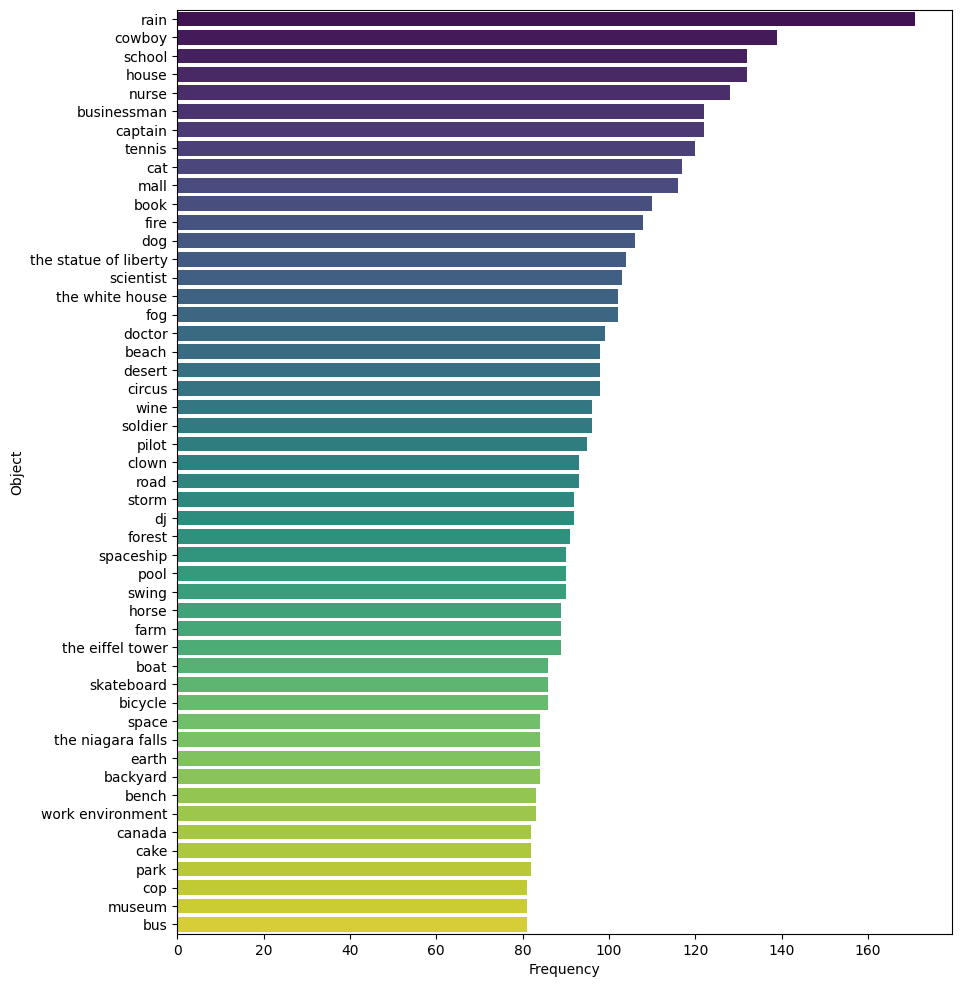

In [12]:
object_stats = objects_stats("Stellar-T", objects_t, plot_graph=True)

## Interacting with the provided PyTorch Dataset

In [ ]:
from stellar_dataset import Stellar

dataset = Stellar(pjoin("output_dir", "STELLAR"))

In [ ]:
sample = dataset[0]
print(sample)
sample["img"]

### Metadata

The metadata can be used for the evaluation of an image

In [ ]:
dataset.get_metadata(sample["index"])